This is the repository for the "Quantum transformer for High Energy Physics Analysis at the LHC", a Google Summer of Code 2023 project by ML4Sci instution QMLHeP group. The purpose of the project is to have a proof-of-concept Quantum Vision Transformer implementation for the jet data classification.

~~It is not possible to implement a QViT using this code yet as the project is still in progress. However this repo will be updated weekly to show the progress.~~\

It is now possible to implement a hybrid QViT transformer on resized mnist data using this project. A blog about midterm progress can be found at:

https://medium.com/@eyupb.unlu/gsoc-2023-with-ml4sci-quantum-transformer-for-high-energy-physics-analysis-at-the-lhc-the-midterm-5cf454b9f12c

Warning: QVIT.pennylane is used up to the transformer training, afterwards QViT.tensorcircuit is used.

In [3]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install pennylane
    !git clone https://github.com/EyupBunlu/QViT_HEP_ML4Sci

<a target="_blank" href="https://colab.research.google.com/github/EyupBunlu/QViT_HEP_ML4Sci">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [11]:

import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
# import seaborn as sns
import math
from tqdm.notebook import tqdm
import time
# from torchvision.datasets import MNIST
# import torchvision.transforms as transforms
# import sklearn.metrics
import h5py
if IN_COLAB: from QViT_HEP_ML4Sci.QViT import *
else: from QViTimport *

torch.set_default_dtype(torch.float64)
torch.set_num_threads(8)
device='cuda'

## First Method

The first method to achieve our goal will be reproducing the architecture in the paper ["Quantum Vision Transformers"](https://arxiv.org/pdf/2209.08167.pdf) (referred as QViT paper in the file) if possible.

Papers of interest

Conference Paper: https://indico.jlab.org/event/459/contributions/11832/ \
Beamsplitter Decomposition Paper: https://arxiv.org/pdf/2212.07389.pdf \
Beamsplitter Qumode Explanation: https://quantumcomputing.stackexchange.com/questions/32286/how-to-represent-beam-splitter-and-kerr-gates-as-basic-quantum-logic-gates\ \
QViT Paper: https://arxiv.org/pdf/2209.08167.pdf \

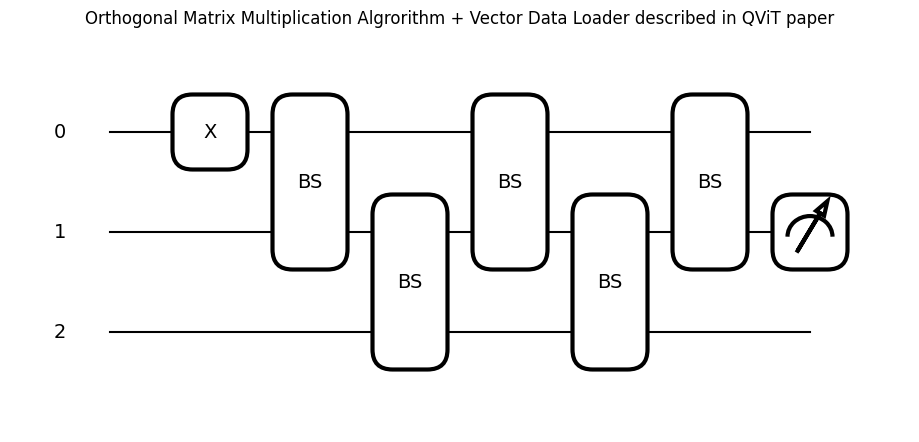

In [3]:
length = 3
qml.draw_mpl(mmult_bs,show_all_wires=True,wire_order=[i for i in range(length)])(torch.zeros(10),torch.ones(2))
q=plt.title('Orthogonal Matrix Multiplication Algrorithm + Vector Data Loader described in QViT paper')

The Beamsplitter gate mentioned in the paper only works with the qumodes. However it can be decomposed as the following combination of gates as explained in the paper
["Quantum Methods for Neural Networks and Application to Medical Image Classification"](https://arxiv.org/pdf/2212.07389.pdf)

Text(0.5, 1.0, 'BeamSplitter Equivalent Structure')

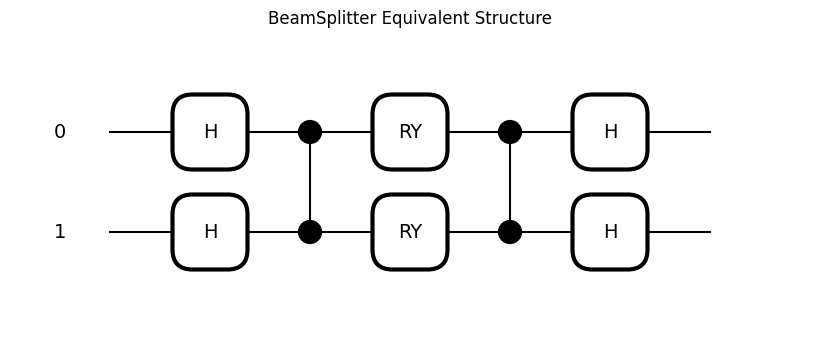

In [4]:
qml.draw_mpl(rbs,show_all_wires=True)([0,1],torch.tensor([0]))
plt.title('BeamSplitter Equivalent Structure')

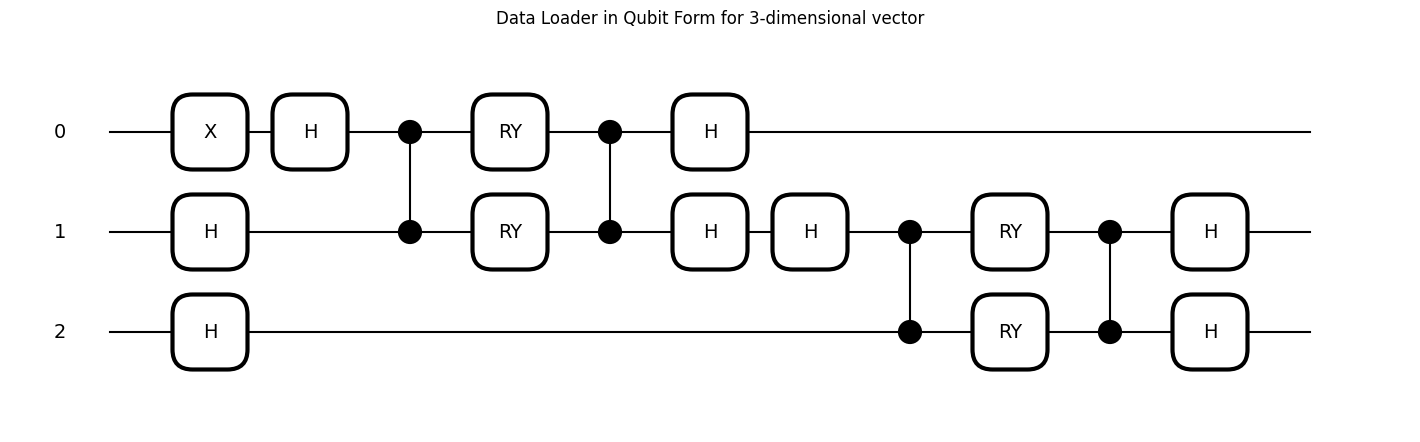

In [5]:
qml.draw_mpl(vector_loader,show_all_wires=True,wire_order=[i for i in range(3)])(torch.ones(2))
q=plt.title('Data Loader in Qubit Form for 3-dimensional vector')
plt.savefig('loader1')

Suggested data loader takes n-1 parameters to load length n data.
Data loader circuit can be expressed as the following.

$$\Psi = \left[\Sigma_{i=0}^{n-2} \left(\Pi^{i-1}_{j=0}\sin \alpha_j \right)e_i \cos \alpha_i \right]+\left(\Pi^{n-1}_{j=0}\sin \alpha_j \right)e_{n-1}$$.
Therefore, one can load normalized vector $x_i$ using the following parameters:
$$\alpha_0 = cos^{-1}(x_0)$$
$$\alpha_i = cos^{-1}\left(x_i  \left[1-\Sigma_{j=0}^{i-1}x_j^2\right]^{-1/2}\right)$$


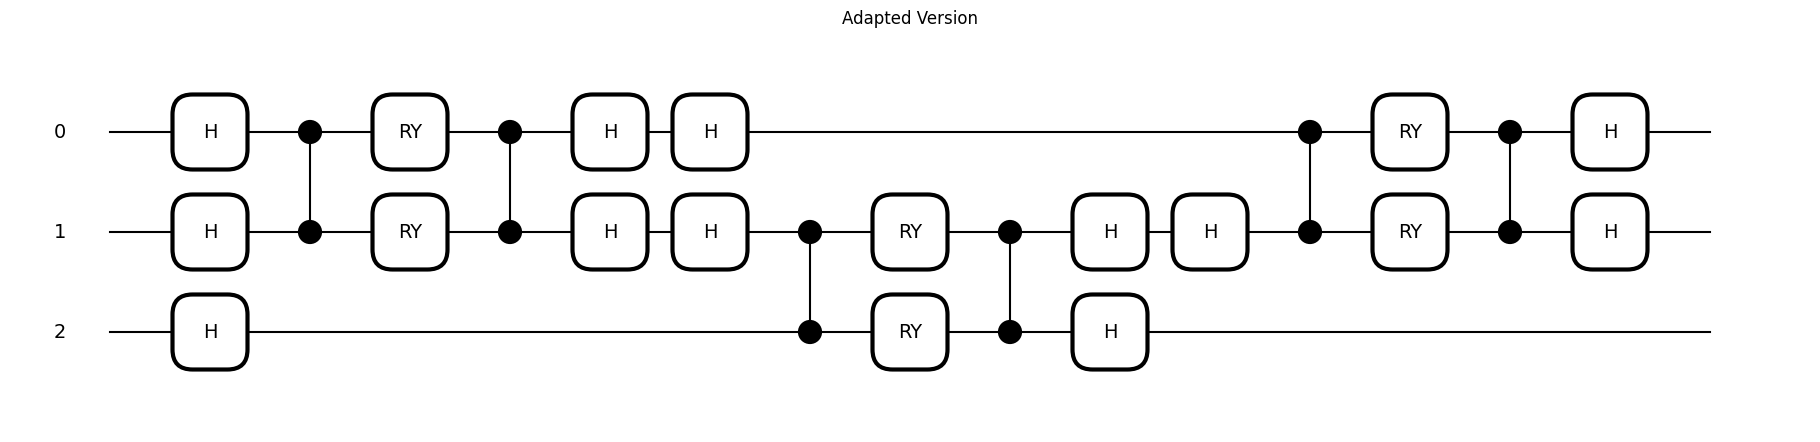

In [6]:
qml.draw_mpl(mmult,show_all_wires=False,wire_order=[i for i in range(5)])(torch.zeros(10),None,3)
q=plt.title('Adapted Version')

### Vector Loader Demonstration

In [7]:
X = torch.tensor([1/2,1/2,1/np.sqrt(2)],requires_grad=False)
alphas = convert_array(X)
wires = [ str(i) for i in range (X.shape[0])]

Loading X: [0.5        0.5        0.70710678]


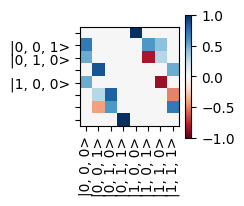

In [8]:
plot_opm(vector_loader,[alphas,wires],wire_order = None)
print('Loading X: {}'.format(X.numpy()))

### Matrix Loader Demonstration

Matrix loader used in the QViT paper consists of multiple vector loaders and some CNOT gates. In order to load a matrix of nxd, one needs to use n+1 many data loaders and n+d qubits. It encodes the data to the qubits as,
$$|\Psi>=\sum_{i,j}^{n,d} \frac{X_{ij}}{||X||} |m_i> \otimes |e_j> $$
where $|m_i>$ are magnitude qubits and $|e_j>$ are vector qubits.

In [9]:
X = torch.tensor([[1,1,1],[0,1,0],[0,0,1]],requires_grad=False)
nrow,ncolumn = X.shape
mag_wires = [ '||X||_'+str(i) for i in range (nrow)]
wires = [ str(i) for i in range (ncolumn)]

mag_alphas,alphas = convert_matrix(X)

In [10]:
mag_alphas

tensor([0.6847, 0.7854])

Data Loader


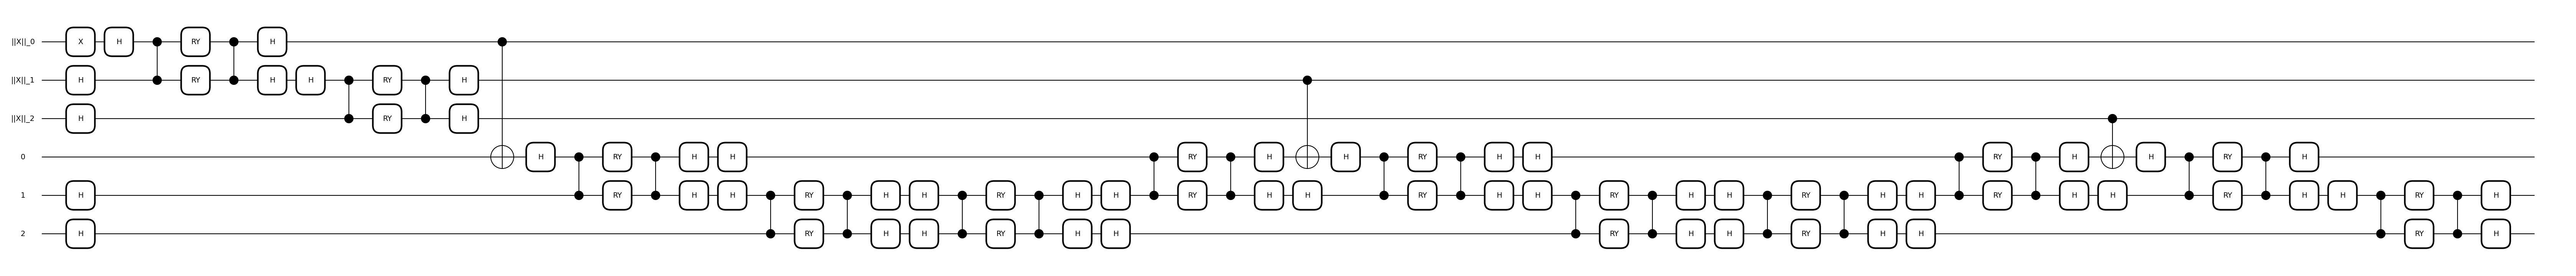

In [11]:
qml.draw_mpl(matrix_loader,show_all_wires=True,wire_order=mag_wires+wires)(mag_alphas,alphas,mag_wires,wires)
# q=plt.title('$\huge{Circuit Form}$')
print('Data Loader')

Text(0.5, 1.0, "Matrix Loader's Matrix Representation for Loading \n X=[[1 1 1]\n [0 1 0]\n [0 0 1]]")

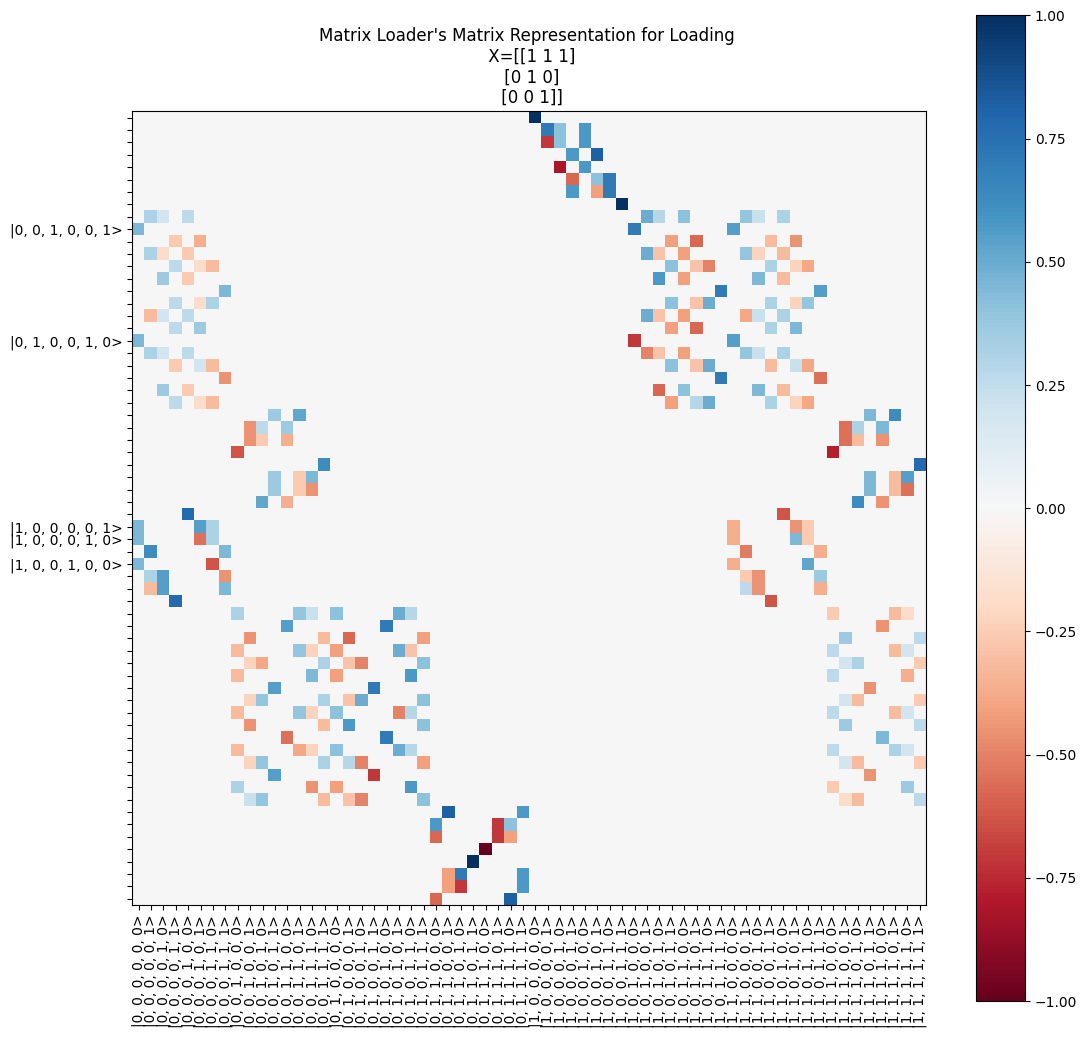

In [12]:
plot_opm(matrix_loader,(mag_alphas,alphas,mag_wires,wires),wire_order = mag_wires+wires)
plt.title('Matrix Loader\'s Matrix Representation for Loading \n X={}'.format(X.numpy()))

### Demonstration of $A_{ij}=x_i^TWx_j$ calculation

In order to calculate the $A_{ij}=x_i^TWx_j$, one needs to load the $|x_j>$ then apply W then load $<x_i|$. \
In order to achieve this we will need d many qubits where our data is a $nxd$ matrix.\
We need to make sure that we multiply our output with the norms of $x_i$ and $x_j$ since our data loader only takes unit normalized vectors as input. \
For this demonstration, A random orthogonal matrix is created and the loss function is set such that it is minimum if W is that matrix. In addition, I took the absolute value of Y as this method doesn't retrieve the sign.

In [13]:
torch.manual_seed(1)
X = torch.rand(5,2,3)*2-1
X = X/(X**2).sum(axis=-1).sqrt()[...,None]
n = X.shape[1]+1
d = X.shape[2]
n_epoch = 100

In [14]:
W_ideal = torch.rand(d,d)-1/2
W_ideal = W_ideal-W_ideal.T
W_ideal = (torch.eye(d)-W_ideal)@(torch.eye(d)+W_ideal).inverse()

Y = torch.einsum('nik,kl,njl->nij',X,W_ideal,X)

alphas = convert_array(X)
norms = (X**2).sum(axis=-1).sqrt()
wires=[i for i in range(d+1)]

(<Figure size 1900x500 with 1 Axes>, <Axes: >)

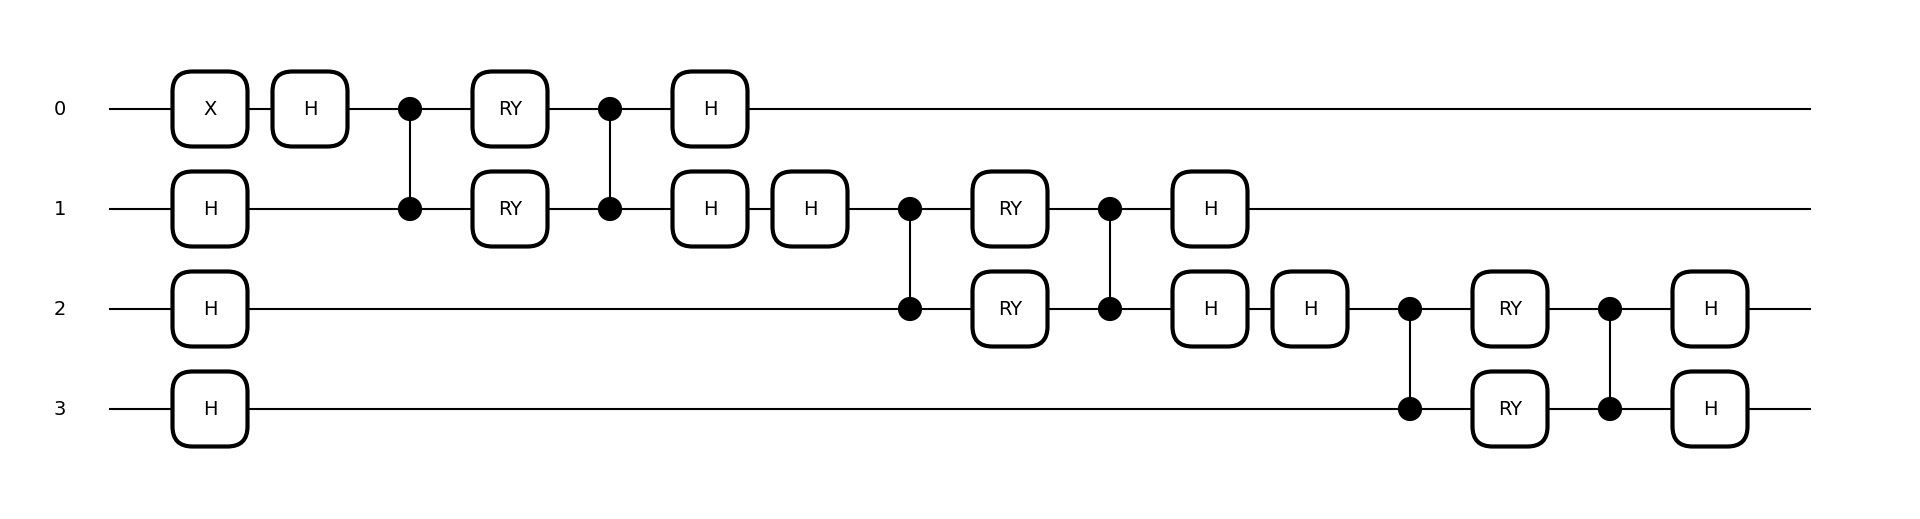

In [15]:
qml.draw_mpl(vector_loader)(torch.rand(d),wires,True,False)

In [16]:
alphas.shape

torch.Size([5, 2, 2])

In [17]:


loss_fn = lambda yhat,y :((yhat-y)**2).sum(axis=[-1,-2]).sqrt().mean()
bar = tqdm(range(n_epoch))
QLayer = circuit_to_layer(compute_attention_element,wires,{'phi':(n**2-n)//2},device=device)
optim=torch.optim.Adam(QLayer.parameters(),lr=5e-2)

for i in bar:
    yhat = []
    optim.zero_grad()
    yhat = compute_attention(alphas.to(device),norms.to(device),QLayer)
    loss_ = loss_fn(yhat,Y.to(device))
    bar.set_postfix_str(loss_.item())
    loss_.backward()
    optim.step()



  0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
phi = list( QLayer.parameters())[0]

In [19]:
print(W_ideal)

tensor([[ 0.5657,  0.7179,  0.4057],
        [-0.8007,  0.5958,  0.0622],
        [-0.1971, -0.3600,  0.9119]])


### Matrix Multiplication on X Demonstration

It would be possible to start creating a transformer once we can perform orthogonal matrix multiplication on the loaded data vector and retrieve the signs. This part will be added later for completeness but it wouldn't be used as it demands too many qubits.

$\textbf{Soon to be Added}$

### Hybrid Transformer

A hybrid transformer structure is implemented below. It is almost identical to a classic ViT except
$$\text{Softmax}\left( \frac{(W_KX) (W_QX)^T)}{\sqrt n}\right)$$
calculation is replaced with
$$\text{Softmax}\left( \frac{QC(W,X)}{\sqrt n}\right)$$
where X (bxnxd) is the input.

QC in this method only calculates
$A_{ij}=x_i^TWx_j$


This approach requires retrieving expectation value of the first qubit for $n^2$ many times where the circuit has d qubits.
Therefore quantum part of this circuit would have $O(n^2f(d))$ where f(d) is the time required for the circuit to retrieve the expectation value.
On the other hand, using a classical method to perform the same operation would have time complexity of $O(nd^2+n^2d)$.

The experimental calculation of f(d) is shown below



Text(0, 0.5, 'f(d) in seconds')

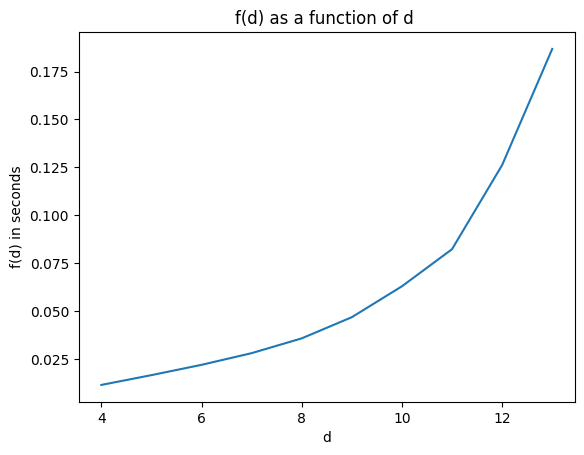

In [20]:
t={}
l=[]
n=10
for i in range(4,14,1):
    X=convert_array(torch.rand(2,i))
    A = circuit_to_layer(compute_attention_element,wires=list(range(i+1)),pars={'phi':(i**2-i)//2})
    t_ = time.time()
    for _ in range(n):A(X.flatten())
    t[i]= (time.time()-t_)/n
    l.append(i)

plt.plot(t.keys(),[t[i] for i in t.keys()])
plt.title("f(d) as a function of d ")
plt.xlabel('d')
plt.ylabel('f(d) in seconds')

In [21]:
t

{4: 0.011350345611572266,
 5: 0.016463041305541992,
 6: 0.021843504905700684,
 7: 0.027939772605895995,
 8: 0.03567056655883789,
 9: 0.046725010871887206,
 10: 0.06286625862121582,
 11: 0.08224492073059082,
 12: 0.12619428634643554,
 13: 0.1868514060974121}

This is a big problem given we will need to perform this operation for $n_{\text{epoch}}n_{\text{samples}}n_{\text{layers}}n_{\text{heads}}n^2$ many times. If we wanted to implement this model for MNIST classification with 14 patches of 14 length arrays, two layers with two heads and 200 data points, an epoch would take $4*14^2*200*.07$ seconds or 10 hours on CPU, not including classical parts.


## Second Method

Papers of interest:\
[Quantum Self-Attention Neural Networks for Text Classification](https://arxiv.org/abs/2205.05625)

This approach is more computation friendly (at least for the case at hand) and more quantum circuit oriented. Instead of computing the coefficients of the attention that is clasiccal like, this approach uses key/query/value to calculate a corresponding key/query coefficient for each row and a vector for the values. Then, it calculates the coefficient constants as 
$$A_{i,j} = -(K{i}-Q{j})^2 $$
$$K_{i} = <\Psi_i|U_K(\theta_K)^\dagger Z_1 U_K(\theta_K) |\Psi_i>  $$
$$Q_{i} = <\Psi_i|U_Q(\theta_Q)^\dagger Z_1 U_Q(\theta_Q) |\Psi_i>. $$
$|\Psi_s>$ is encoded version of the $s^{\text{th}}$ row vector and can be expressed as,

$$|\Psi_s> = \Pi_{i=0} RX(x_i) H^{\otimes n} |0^n>.$$

The paper also mentions a method for Value matrix as well, which will be implemented by next week.

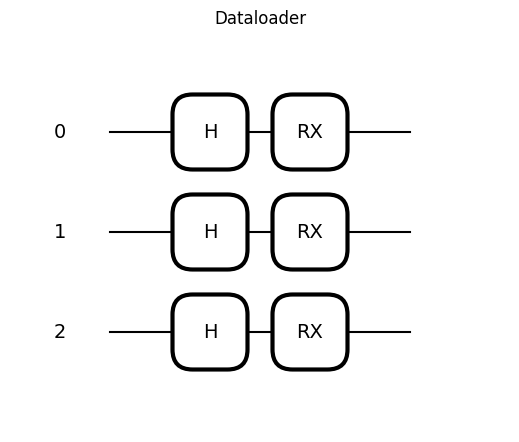

In [6]:
n_wires= 3
wires = list(range(n_wires))
phi = torch.rand(n_wires,4).flatten()
data = torch.rand(3,n_wires)
qml.draw_mpl(encode_token,wire_order=(list(range(n_wires))))(data)
plt.title('Dataloader')

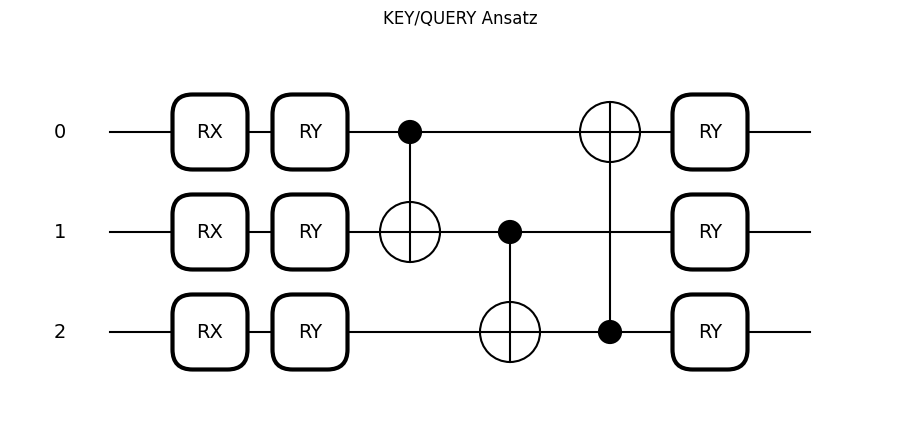

In [19]:
n_wires= 3
wires = list(range(n_wires))
phi = torch.rand(n_wires,4).flatten()
data = torch.rand(3,n_wires)
qml.draw_mpl(qkv_ansatz,wire_order=(list(range(n_wires))))(data,phi)
plt.title('KEY/QUERY Ansatz')
plt.savefig('kq')

# Transformer Experiments

## MNIST Data/Training

In [6]:


mnist_trainset = MNIST(root='./data', train=True, download=True)
n,d= 7,28

transform = transforms.Compose([ transforms.Resize((14,14)), transforms.ConvertImageDtype(torch.float64),transforms.Normalize(0,1)])
data = mnist_trainset.data

data = transform(data)
# data = data/255

data_patched = patcher(data,[2,14])
mnist_trainset = simple_dataset(data_patched,mnist_trainset.targets)
tr_len = 4000
val_len = 1000
tr_set,val_set,test_set = torch.utils.data.random_split(mnist_trainset,[tr_len,val_len,mnist_trainset.target.shape[0]-tr_len-val_len])
tr_dl = DataLoader(tr_set,batch_size=32,shuffle=True)
val_dl = DataLoader(val_set,batch_size=32,shuffle=True)



/home/e_asus/.conda/envs/tc/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [34]:
n_layers = 2
FC_layers = [10]
n_h =4

### Classic Training

In [38]:
model = HViT(n,d,n_layers=n_layers,n_h=n_h,FC_layers=FC_layers,attention_type='classic',embed_dim=d,ff_dim=2*d).to(device)
optim = torch.optim.Adam(model.parameters(),lr=1e-3)
n_epochs = 100
loss_fn = nn.CrossEntropyLoss(reduction='none')
history = train(model,tr_dl,val_dl,loss_fn,optim,n_epochs,device='cuda')

/home/e_asus/.conda/envs/tc/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

# of parameters: 8914
Wrongly Predicted Ratio:0.143


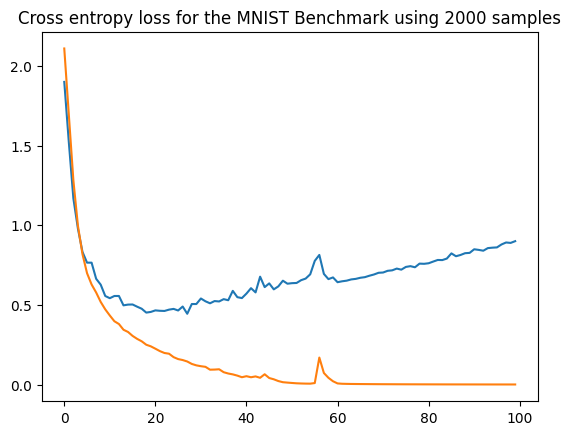

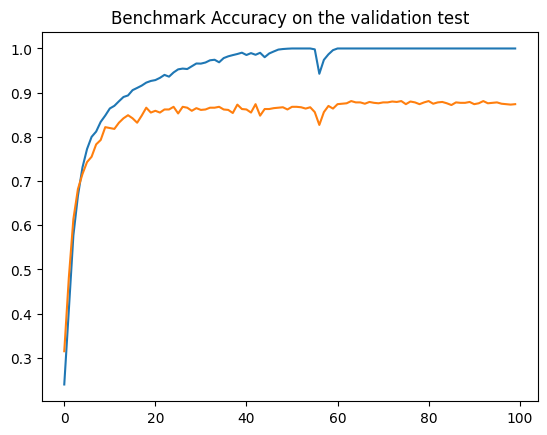

In [41]:
print(f'# of parameters: {sum([np.prod(i.shape) for i in model.parameters()])}')
model.load_state_dict(torch.load('best_state_on_training'))
plt.plot(history['val'],label='val_loss')
plt.plot(history['tr'],label='tr_loss')
plt.title('Cross entropy loss for the MNIST Benchmark using 2000 samples')
plt.figure()
plt.plot(history['tr_acc'],label='val')
plt.plot(history['val_acc'],label='tr')
plt.title('Benchmark Accuracy on the validation test')
pred = model(test_set.dataset.data[test_set.indices[:1000]].to(device)).cpu().argmax(axis=1)

# plt.figure()
# plt.imshow(sklearn.metrics.confusion_matrix(pred.cpu(),test_set.dataset.target[test_set.indices[:1000]],normalize='true'))
# plt.colorbar()
# plt.title('The normalized confusion matrix')
print(f'Wrongly Predicted Ratio:{ (pred != test_set.dataset.target[test_set.indices[:1000]]).sum()/pred.shape[0]}')


In [42]:
max(history['val_acc']),1-(pred != test_set.dataset.target[test_set.indices[:1000]]).sum()/pred.shape[0]

(tensor(0.8810), tensor(0.8570))

In [33]:
max(history['val'])

1.8563576546949696

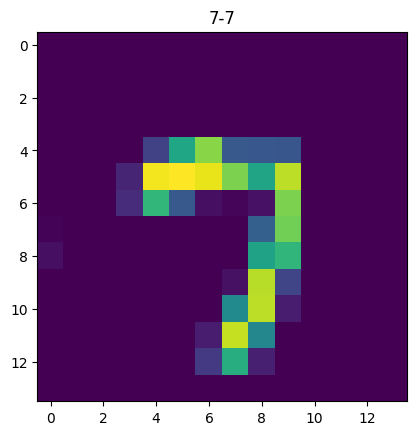

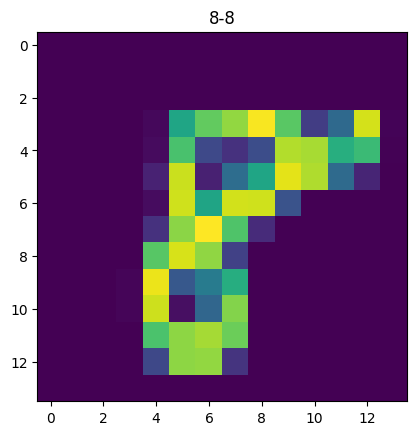

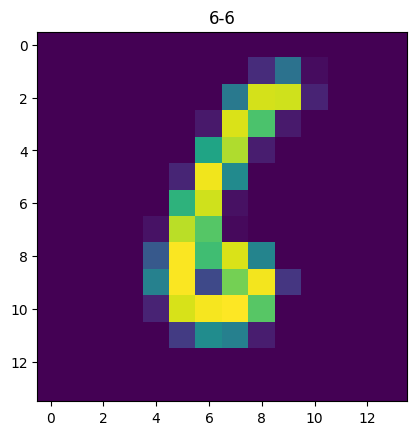

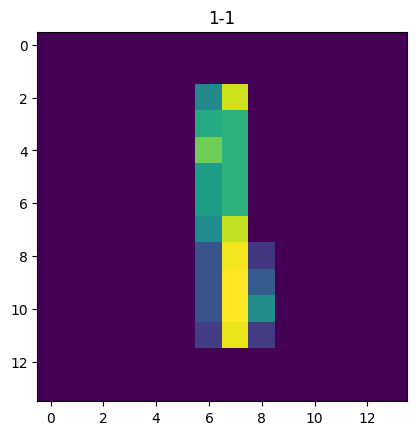

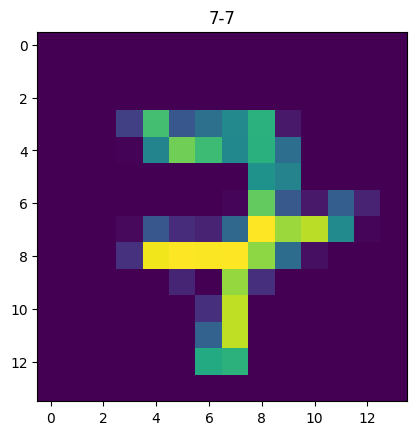

In [8]:
for i in range(5):
    plt.figure()
    ii = test_set.indices[i]
    plt.imshow(data[ii].cpu())
    plt.title(f'{mnist_trainset.target[ii]}-{model(data_patched[[ii]].to(device)).cpu().argmax().item()}')

### Hybrid1 Training

In [6]:
model = HViT(n,d,n_layers=n_layers,n_h=n_h,FC_layers=FC_layers,attention_type='hybrid1').to(device)
optim = torch.optim.Adam(model.parameters(),lr=1e-3)
n_epochs = 100
loss_fn = nn.CrossEntropyLoss(reduction='none')
history = train(model,tr_dl,val_dl,loss_fn,optim,n_epochs,device=device)

NameError: name 'circuit_to_layer' is not defined

# of parameters: 7514
Wrongly Predicted Ratio:0.1542909090909091


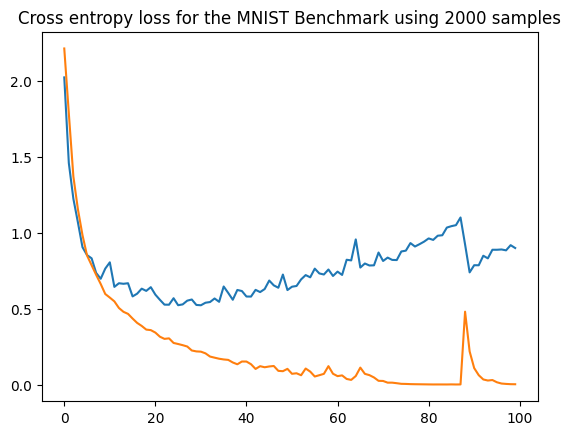

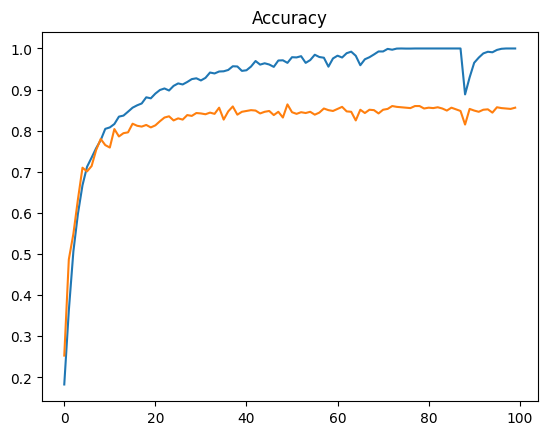

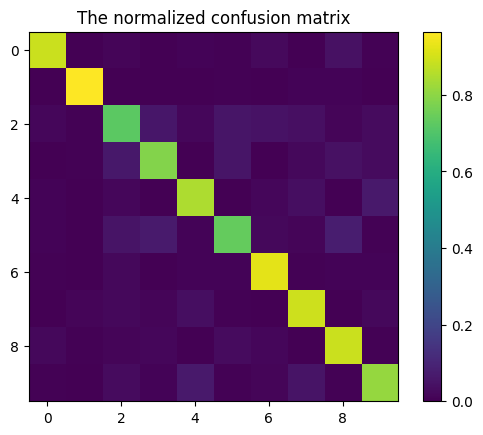

In [20]:
print(f'# of parameters: {sum([np.prod(i.shape) for i in model.parameters()])}')
model.load_state_dict(torch.load('best_state_on_training'))
plt.plot(history['val'],label='val_loss')
plt.plot(history['tr'],label='tr_loss')
plt.title('Cross entropy loss for the MNIST Benchmark using 2000 samples')
plt.figure()
plt.plot(history['tr_acc'],label='val')
plt.plot(history['val_acc'],label='tr')
plt.title('Accuracy')
plt.figure()
pred = model(test_set.dataset.data[test_set.indices].to(device)).cpu().argmax(axis=1)
plt.imshow(sklearn.metrics.confusion_matrix(pred.cpu(),test_set.dataset.target[test_set.indices],normalize='true'))
plt.colorbar()
plt.title('The normalized confusion matrix')
print(f'Wrongly Predicted Ratio:{ (pred != test_set.dataset.target[test_set.indices]).sum()/pred.shape[0]}')


### Hybrid2 Training

In [15]:
model = HViT(n,d,n_layers=n_layers,n_h=n_h,FC_layers=FC_layers,attention_type='hybrid2',embed_dim=d,ff_dim=None).to(device)
optim = torch.optim.Adam(model.parameters(),lr=1e-3)
n_epochs = 100
loss_fn = nn.CrossEntropyLoss(reduction='none')
history = train(model,tr_dl,val_dl,loss_fn,optim,n_epochs,device=device)

/home/e_asus/OneDrive/UF_Research/SoC/QViTHEP/QViT/tensorcircuit/model.py:59: UserWarning: ff_dim is not utilized since no ff
  warnings.warn("ff_dim is not utilized since no ff")
/home/e_asus/.conda/envs/tc/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

# of parameters: 2026
Wrongly Predicted Ratio:0.181


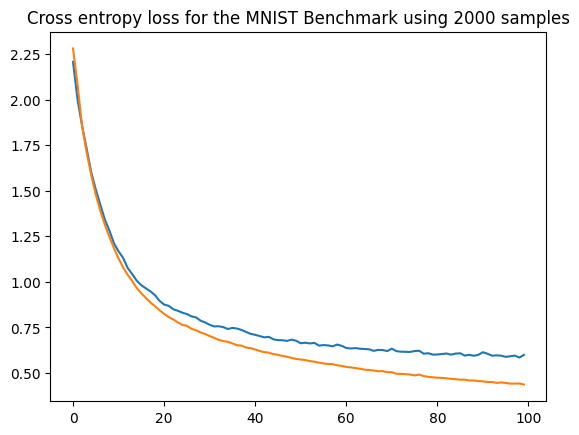

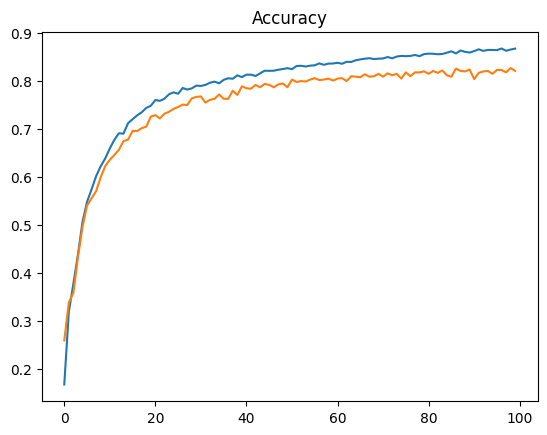

<Figure size 640x480 with 0 Axes>

In [21]:
print(f'# of parameters: {sum([np.prod(i.shape) for i in model.parameters()])}')
model.load_state_dict(torch.load('best_state_on_training'))
plt.plot(history['val'],label='val_loss')
plt.plot(history['tr'],label='tr_loss')
plt.title('Cross entropy loss for the MNIST Benchmark using 2000 samples')
plt.figure()
plt.plot(history['tr_acc'],label='val')
plt.plot(history['val_acc'],label='tr')
plt.title('Accuracy')
plt.figure()
with torch.no_grad():pred = model(test_set.dataset.data[test_set.indices[:1000]].to(device)).cpu().argmax(axis=1)
# plt.imshow(sklearn.metrics.confusion_matrix(pred.cpu(),test_set.dataset.target[test_set.indices],normalize='true'))
# plt.colorbar()
# plt.title('The normalized confusion matrix')
print(f'Wrongly Predicted Ratio:{ (pred != test_set.dataset.target[test_set.indices[:1000]]).sum()/pred.shape[0]}')


In [24]:
max(history['val_acc']),1-(pred != test_set.dataset.target[test_set.indices[:1000]]).sum()/pred.shape[0]

(tensor(0.8260), tensor(0.8190))

In [ ]:
for i in range(5):
    plt.figure()
    ii = test_set.indices[i]
    plt.imshow(data[ii].cpu())
    plt.title(f'{mnist_trainset.target[ii]}-{model(data_patched[[ii]].to(device)).cpu().argmax().item()}')

In [43]:
e = h5py.File('../electron.hdf5')
p = h5py.File('../photon.hdf5')
n_data=20000
data = torch.cat([torch.from_numpy(e['X'][:][:n_data]),torch.from_numpy(p['X'][:][:n_data])],axis=0)
targets = torch.cat([torch.from_numpy(e['y'][:][:n_data]),torch.from_numpy(p['y'][:][:n_data])],axis=0)                 
e.close()
p.close()

In [44]:
def patcher_with_color(data,sh):
    r,c = sh

    rmax = (data.shape[-3]//r)
    cmax = (data.shape[-2]//c)

    patched = torch.empty(*data.shape[:-3],2*rmax*cmax,r*c,device=data.device)
    n=0
    for i in range(rmax):
        for j in range(cmax):
            for k in range(2):
                
                patched[...,n,:] = data[...,(i*r):(i*r+r),(j*c):(j*c+c),k].flatten(start_dim = -2)
                n+=1
    return patched


In [45]:
tr_len = round(data.shape[0]*.9)
val_len = data.shape[0]-tr_len

normalize = transforms.Normalize((0,0),(1,1))
# data_patched = patcher_with_color(normalize(data.swapaxes(-1,1)).swapaxes(-1,1),[4,8])
a = torch.maximum(data.abs().amax(axis=[1,2]),1e-5*torch.ones(data.shape[0],data.shape[-1]))
data_patched = patcher_with_color(data/a[:,None,None,:],[4,8])

jet_simple = simple_dataset(data_patched.type(torch.float64),targets.type(torch.int64))

tr_set,val_set = torch.utils.data.random_split(jet_simple,[tr_len,val_len])
tr_dl = DataLoader(tr_set,batch_size=128,shuffle=True)
val_dl = DataLoader(val_set,batch_size=128,shuffle=True)
n_layers = 8
n_h = 8
FC_layers = [2]

In [46]:
data_patched.shape

torch.Size([40000, 64, 32])

In [48]:
model = HViT(data_patched.shape[-2],data_patched.shape[-1],n_layers=n_layers,n_h=n_h,FC_layers=FC_layers,attention_type='classic',embed_dim = 32,ff_dim=256).to(device)
optim = torch.optim.Adam(model.parameters(),lr=5e-3)
n_epochs = 100
loss_fn = nn.CrossEntropyLoss(reduction='none')
history = train(model,tr_dl,val_dl,loss_fn,optim,n_epochs,device=device)

/home/e_asus/OneDrive/UF_Research/SoC/QViTHEP/QViT/tensorcircuit/model.py:59: UserWarning: ff_dim is not utilized since no ff
  warnings.warn("ff_dim is not utilized since no ff")
/home/e_asus/.conda/envs/tc/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

# of parameters: 138370


<Figure size 640x480 with 0 Axes>

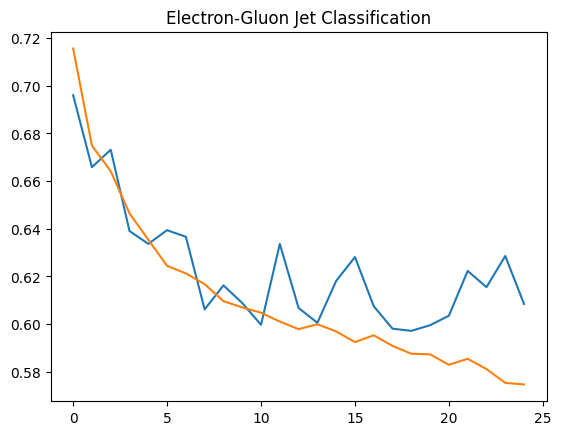

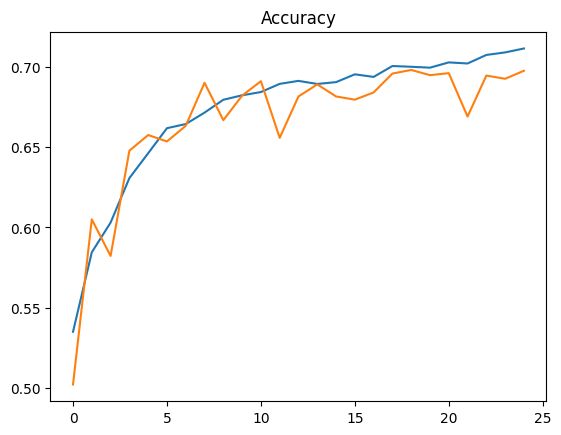

<Figure size 640x480 with 0 Axes>

In [17]:
print(f'# of parameters: {sum([np.prod(i.shape) for i in model.parameters()])}')
model.load_state_dict(torch.load('best_state_on_training'))
plt.plot(history['val'],label='val_loss')
plt.plot(history['tr'],label='tr_loss')
plt.title('Electron-Gluon Jet Classification')
plt.figure()
plt.plot(history['tr_acc'],label='val')
plt.plot(history['val_acc'],label='tr')
plt.title('Accuracy')
plt.figure()

## Jet Classifier 

In [ ]:
e = h5py.File('../electron.hdf5')
p = h5py.File('../photon.hdf5')
n_data=int(1e5)
data = torch.cat([torch.from_numpy(e['X'][:][:n_data]),torch.from_numpy(p['X'][:][:n_data])],axis=0)
targets = torch.cat([torch.from_numpy(e['y'][:][:n_data]),torch.from_numpy(p['y'][:][:n_data])],axis=0)                 
e.close()
p.close()

In [ ]:
def patcher_with_color(data,sh):
    r,c = sh

    rmax = (data.shape[-3]//r)
    cmax = (data.shape[-2]//c)

    patched = torch.empty(*data.shape[:-3],2*rmax*cmax,r*c,device=data.device)
    n=0
    for i in range(rmax):
        for j in range(cmax):
            for k in range(2):
                
                patched[...,n,:] = data[...,(i*r):(i*r+r),(j*c):(j*c+c),k].flatten(start_dim = -2)
                n+=1
    return patched


In [ ]:
mean = data.amax(dim=[1,2]).mean(axis=0)
std = data.amax(dim=[1,2]).std(axis=0)


In [ ]:
torch.manual_seed(0)
tr_len = round(data.shape[0]*.9)
val_len = data.shape[0]-tr_len


# data_patched = patcher_with_color((data-mean[None,None,None,:])/std[None,None,None,:],[4,8])

j_min = data.abs().amin(dim=[0,1,2])[None,None,None,:]
j_range = data.amax(dim=[0,1,2])[None,None,None,:] - data.abs().amin(dim=[0,1,2])[None,None,None,:]
data_patched = patcher_with_color((data-j_min)/j_range,[4,8])
data_patched[data_patched.isnan()]=0



In [ ]:
batch_size=512
jet_simple = simple_dataset(data_patched.type(torch.float64),targets.type(torch.int64))

tr_set,val_set = torch.utils.data.random_split(jet_simple,[tr_len,val_len])
tr_set.indices = tr_set.indices[:(len(tr_set.indices)//batch_size)*batch_size] 
val_set.indices = val_set.indices[:(len(val_set.indices)//batch_size)*batch_size] 
tr_dl = DataLoader(tr_set,batch_size=batch_size,shuffle=True)
val_dl = DataLoader(val_set,batch_size=batch_size,shuffle=True)

In [10]:
transformer_dims = {'d_t':data_patched.shape[-2],'d_k':data_patched.shape[-1]}
transformer_hyper = {'n_layers':4,'FC_layers':[32,1],
                    'n_h':8,'embed_dim': 16,'ff_dim':32}
transformer_type = {'classifying_type':'mean','pos_embedding':True}

### Classic

In [11]:
torch.manual_seed(0)
model = HViT(**transformer_dims,**transformer_hyper,**transformer_type,attention_type='classic').to(device)

/home/eyup.unlu/.conda/envs/qml/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:

optim = torch.optim.Adam(model.parameters(),lr=5e-3)
n_epochs = 50
def loss_fn(yhat,y):
    return nn.BCEWithLogitsLoss(reduction='none')(yhat.squeeze(),y.float())
# loss_fn = nn.CrossEntropyLoss(reduction='none')
history = train(model,tr_dl,val_dl,loss_fn,optim,n_epochs,device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

In [61]:
model(data_patched[[0]].to(device))
print(f'# of parameters| {sum([np.prod(i.shape) for i in model.parameters()])}')
model.load_state_dict(torch.load('best_state_on_training'))

# of parameters| 5985


<All keys matched successfully>

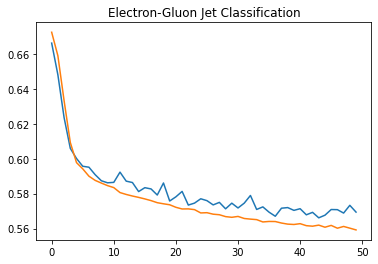

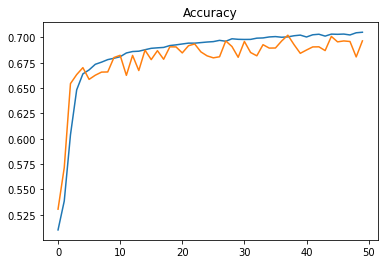

In [62]:

plt.plot(history['val'],label='val_loss')
plt.plot(history['tr'],label='tr_loss')
plt.title('Electron-Gluon Jet Classification')
plt.savefig("cls_loss.jpg")
plt.figure()
plt.plot(history['tr_acc'],label='val')
plt.plot(history['val_acc'],label='tr')
plt.title('Accuracy')

plt.savefig("cls_acc.jpg")

In [63]:
with torch.no_grad(): yhat = model(val_dl.dataset.dataset[val_dl.dataset.indices]['input'].to(device))

In [64]:
from sklearn.metrics import roc_auc_score,roc_curve


In [65]:
yhat = yhat.cpu()
roc_auc_score(val_dl.dataset.dataset[val_dl.dataset.indices]['output'],yhat)


0.7775774308366558

In [66]:
((yhat.squeeze()>.5)==val_dl.dataset.dataset[val_dl.dataset.indices]['output']).sum()/2e4

tensor(0.6859)

In [67]:
res = roc_curve(val_dl.dataset.dataset[val_dl.dataset.indices]['output'],yhat)

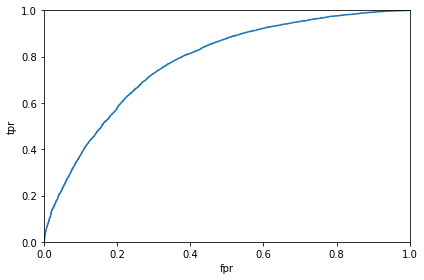

In [70]:
# plt.figure()
res = roc_curve(val_dl.dataset.dataset[val_dl.dataset.indices]['output'],yhat)
plt.plot(res[0],res[1])
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.xlim([0,1])
plt.ylim([0,1])
plt.tight_layout()

plt.savefig("roc_cls.jpg")

### Hybrid2

In [ ]:


class QLayer(nn.Module):
    
    def circuit_to_func(self,K,func,nqubits):
        def f(inputs,phi):
            return func(inputs,phi,nqubits)

        f_vmap = K.vmap(f)
        # f_pmap = pmap(f,in_axes=(0, None))


        f_batch = tc.interfaces.torch_interface(f_vmap, jit=True)

        
        return f_batch

    def __init__(self,func,par_sizes,nqubits):
        super(QLayer,self).__init__()
        self.K = tc.set_backend("jax")
        self.w = nn.Parameter(torch.normal(0,1/par_sizes[-1]**.5*torch.ones(par_sizes)) )
        self.f = self.circuit_to_func(self.K,func,nqubits)
    def forward(self,input1):
        return self.f(input1,self.w)



In [ ]:
transformer_dims = {'d_t':data_patched.shape[-2],'d_k':data_patched.shape[-1]}
transformer_hyper = {'n_layers':4,'FC_layers':[32,1],
                    'n_h':8,'embed_dim': 32,'ff_dim':32}
transformer_type = {'classifying_type':'max','pos_embedding':True}

In [29]:
model = HViT(**transformer_dims,**transformer_hyper,**transformer_type,attention_type='hybrid2').to(device)
# model.load_state_dict(torch.load('best_state_on_training_acc'))
# print(f'# of parameters: {sum([np.prod(i.shape) for i in model.parameters()])}')

/home/eyup.unlu/.conda/envs/qml/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:

optim = torch.optim.Adam(model.parameters(),lr=5e-3)
n_epochs =20
def loss_fn(yhat,y):
    return nn.BCEWithLogitsLoss(reduction='none')(yhat.squeeze(),y.float())
# loss_fn = nn.CrossEntropyLoss(reduction='none')
history = train(model,tr_dl,val_dl,loss_fn,optim,n_epochs,device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

# Future Goal's

Goal's Achieved from 5/25 to 6/7:

- Implementing Beam splitter equivalent for a Qubit circuit.
- How to parametrize data for the circuit\
- Loading a vector\
- Applying a matrix multiplication on a loaded vector.
- Training the mentioned matrix.

Goal's Achieved from 6/7 to 6/14:
- Loading a data matrix
- Cleaning the code
- Documentation and tidying up the github repo

Goal's Achieved from 6/14 to 6/21:
- Busy week, no progress.

Goal's Achieved from 6/21 to 07/05:
- Calculating $|<x_j|A|x_i>|$ using quantum circuits
- Implementing a hybrid vision transformer,

Goal's Achieved from 7/5 to 7/12:
- Speeding up the previous model
- Implementing a 2nd different and faster hybrid vision transformer
- Setting up the training on MNIST (14x14)

Goal's Achieved from 7/12 to 7/19:
- Debugged the transformer architecture for the benchmark ViT
- Training the benchmark
- Fixed a bug in parametrization for the Cherrat et al paper
- Code works in GPU if device is set to cuda

Goal's Achieved from 7/19 to 8/02:
- Apply the debug fixes to the QViT architectures
- Training and Benchmarking the mentioned hybrid transformer on the mnist dataset


Goal's Achieved from 7/19 to 8/02:
- Started testing on jet data: classic model peaks at .7 accuracy for some reason, still investigating.
- Moved to tensor circuit, orders of magnitude ($\approx$ 15) faster!!!
  
Future goals for the next week:\
- Explore hyperparameter space
- Explore different modifications
